L'obiettivo del nostro progetto è prevedere il tipo di copertura forestale basandoti su variabili cartografiche
1. Importiamo librerie

In [79]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

2. Acquisizione dei Dati
Acquisiamo i dati del nostro database e visualizziamo le sue caratteristiche

In [81]:
# Carichiamo i dati dal file CSV
data = pd.read_csv('cover_data.csv')
fraction_of_data = 0.1
data = data.sample(frac=fraction_of_data)
#Rinominiamo l'intestazione di una colonna ch epuò essere confondibile
data = data.rename(columns={'class': 'Cover_Type'})
# Visualizziamo le prime righe del DataFrame
print(data.head())
# Visualizziamo le informazioni sul DataFrame( tipo di ogni colonna, valori non-nulli e l'uso della memoria)
print(data.info())
# Visualizziamo le statistiche descrittive dei dati
print(data.describe())
# Contiamo le occorrenze di ciascun tipo di copertura forestale
print(data['Cover_Type'].value_counts())


        Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
514130       3130      40     27                               150   
441722       3065     311     23                               180   
83825        2939     257     14                               366   
246597       2108     304     34                               108   
73116        3001     101     17                               175   

        Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
514130                              35                             1328   
441722                              44                             2899   
83825                               36                             5452   
246597                              29                              721   
73116                               10                             3564   

        Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
514130            211             169             77   
441722          

Considerazioni:
- dati ben organizzati, con grande varietà e non vi sono dati mancanti
- vi sono delle variabili categoriche che sono state già converite in binarie-> non ci sarà bisogno di fare modifiche
- potrebbe essere necessario un bilanciamento dei dati di addestramento per non pregiudicare il modello
- potrebbe essere utile normalizzare o standardizzare i dati

3. Suddivsione dei dati in set di addestramento, validazione e test

In [82]:
X = data.drop('Cover_Type', axis=1)  # features
y = data['Cover_Type']  # target
# Prima suddivisione: Separare i dati in set di addestramento e temp (quest'ultimo sarà poi suddiviso in validazione e test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Seconda suddivisione: Dividere i dati temp in set di validazione e test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

i nostri dati suddivisi:
- X_train, y_train - per l'addestramento
- X_val, y_val - per la validazione
- X_test, y_test - per il test

4. Pre-Elaborazione dei dati(ci vogliono 6 minuti)

4.1 Bilanciamento dei dati modello con metodo Smote 
Decidiamo di utilizzare Smote perché riesce a limitare l'overfitting

Cover_Type
2    19860
7    19860
1    19860
5    19860
6    19860
3    19860
4    19860
Name: count, dtype: int64


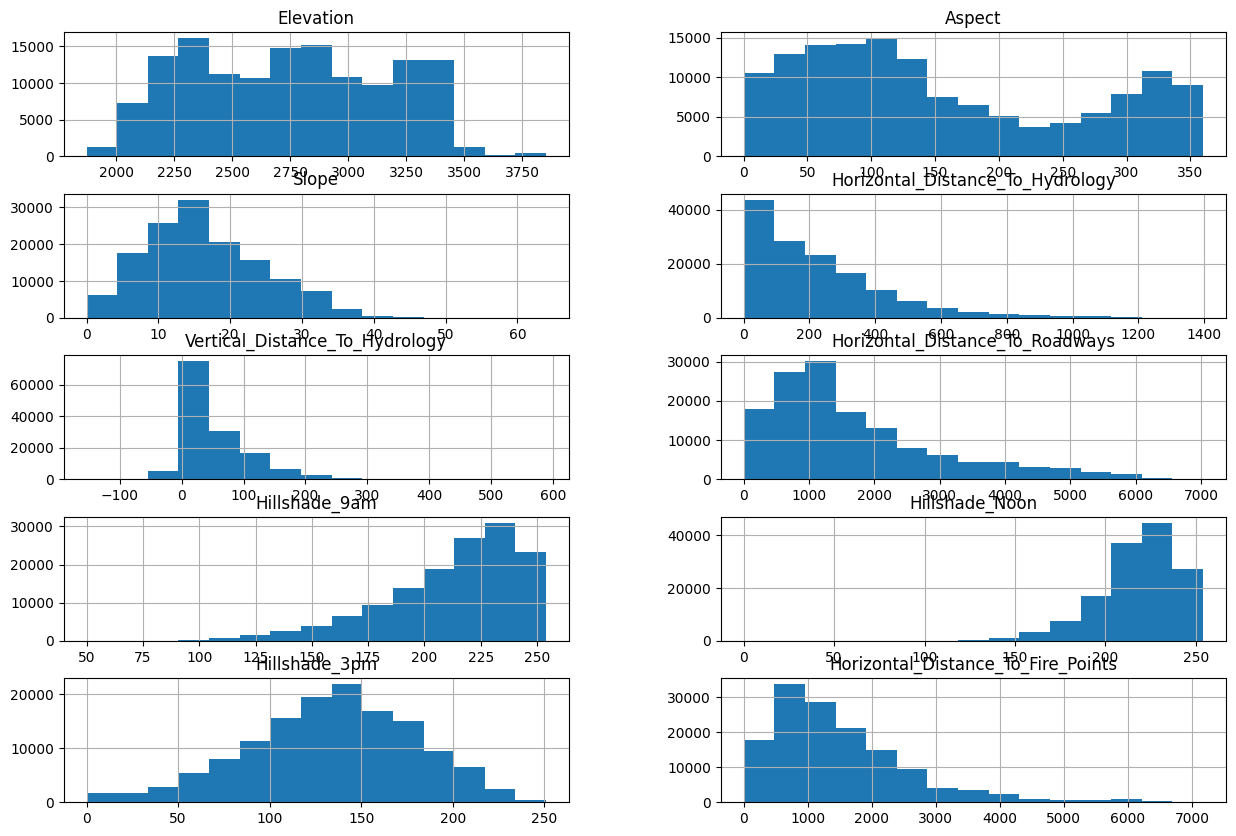

In [83]:
#Bilanciamento dei dati con SMOTE
smote = SMOTE()
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
quantitative_columns = [
    'Elevation', 'Aspect', 'Slope', 
    'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 
    'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
]
#visualizziamo le distribuzione delle features, è utile pre comprendere dove andare ad effettuare standardizzazione o normalizzazione
X_train_res[quantitative_columns].hist(bins=15, figsize=(15, 10), layout=(5, 2))
#verifichiamo che la distribuzione sia stata svolta, ci serve anche per conoscere quanti dati abbiamo a disposizone 
print(y_train_res.value_counts())

4.2 Standardizzazione, Noramlizzazione e trasformazione logaritmica dei dati:
- Standardizzazione: 'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology'
- Trasformazione log: 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'


In [84]:
#Standardizziamo i dati 
standardize_columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']
log_transform_columns = ['Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

# Creare i trasformatori per le diverse colonne
preprocessor = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), standardize_columns),
        ('log', FunctionTransformer(np.log1p), log_transform_columns)  # log1p è usato per gestire il caso in cui abbiamo zero nei dati
    ],
    remainder='passthrough'  # Le altre colonne non specificate non vengono trasformate
)

# Creare un pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Adattare il pipeline ai dati di addestramento e trasformarli
X_traint = pipeline.fit_transform(X_train_res)

# Trasformare i set di validazione e test senza riadattare
X_valt = pipeline.transform(X_val)
X_testt = pipeline.transform(X_test)

#Dobbiamo effettuare anche un'altra trasformazione: in sparse_categorical_crossentropy le etichette devono partire da 0 e poi aumentare invece nel caso di Cover_Type essa parte da 1
y_train_res = y_train_res - 1
y_test = y_test - 1
y_val=y_val -1

5. Creiamo il nostro modello

In [85]:
pca = PCA(n_components=0.95)
X_traint=pca.fit_transform(X_traint)
n_features = X_traint.shape[1]
def build_model(n_layers=2, n_neurons=64, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(n_neurons, activation='relu', input_shape=(n_features,)))
    for _ in range(n_layers - 1):
        model.add(Dense(n_neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(7, activation='softmax'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Wrap the model so it can be used by scikit-learn
keras_model = KerasClassifier(build_fn=build_model, epochs=100, batch_size=512, verbose=1)

# Define the parameter grid
param_grid = {
    'n_layers': [2, 3],  # meno layer
    'n_neurons': [64],  # meno neuroni
    'dropout_rate': [0.5],  # meno opzioni per dropout
    'learning_rate': [0.001],  # meno opzioni per learning_rate
}

# Create and fit the GridSearchCV or RandomizedSearchCV
grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3, n_jobs=2) 
grid_search.fit(X_traint, y_train_res)

# Print the best parameters and best accuracy
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_.model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}, Test loss: {test_loss}')


49290.88s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
49290.89s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
2024-01-21 14:04:44.706177: F tensorflow/c/experimental/stream_executor/stream_executor.cc:743] Non-OK-status: stream_executor::MultiPlatformManager::RegisterPlatform( std::move(cplatform)) status

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6)}

In [ ]:
# Stampa del riepilogo del modello
model.summary()

# Addestramento del modello
history = model.fit(
    X_traint, y_train_res,
    validation_data=(X_valt, y_val),
    epochs=10,  # Numero di epoche
    batch_size=32  # Dimensione del batch
)